## Объявление функций

In [1]:
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import trange
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from fastdtw import fastdtw
from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 2

from tscnn_classifier import TimeSeriesCNN
from plot_functions import plot_metrics, plot_aug, plot, plot_results
from train import train

In [3]:
batch_size = 50
criterion = nn.BCELoss()
num_epochs = 8
n_experiments = 3
augments_per_sample = 1

In [4]:
def load_data(dataset, old=False):
    if old:
        if dataset == "ihb":
            close = np.load("close_mean_ts_by_network.npy")
            open = np.load("open_mean_ts_by_network.npy")
        elif dataset == "china":
            open = np.load("china_open_mean_ts_by_network_HCPex.npy")
            close = np.load("china_close_mean_ts_by_network_HCPex.npy")
        elif dataset == "china_cut":
            open = np.load("china_open_mean_ts_by_network_HCPex.npy")
            close = np.load("china_close_mean_ts_by_network_HCPex.npy")
            close = close[:, :48, :]
        else:
            print("dataset must be ihb, china or china_cut.")
            return

        data = np.concatenate((close, open), axis=1)
        data = torch.tensor(data).float()
        data = data.reshape((data.shape[1], data.shape[0], data.shape[2]))
        return close, open, data
    else:
        if dataset == "ihb":
            close = np.load("ihb_close_mean_HCPex.npy")
            open = np.load("ihb_open_mean_HCPex.npy")
        elif dataset == "china":
            open = np.load("china_open_mean_HCPex.npy")
            close = np.load("china_close_mean_HCPex.npy")
        elif dataset == "china_cut":
            open = np.load("china_open_mean_HCPex.npy")
            close = np.load("china_close_mean_HCPex.npy")
            close = close[:48]
        else:
            print("dataset must be ihb, china or china_cut.")
            return
        data = np.concatenate((close, open), axis=0)
        data = torch.tensor(data).float()
        data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
        close = close.reshape((close.shape[2], close.shape[0], close.shape[1]))
        open = open.reshape((open.shape[2], open.shape[0], open.shape[1]))
        return close, open, data


In [5]:
def conduct_experiments(data, labels, conv_output_size=1120, num_epochs=num_epochs):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
    metrics = []
    
    for _ in range(n_experiments):
        for _, (train_index, test_index) in enumerate(kf.split(data, labels)):
            
            train_data = data[train_index]
            train_labels = labels[train_index]
            test_data = data[test_index]
            test_labels = labels[test_index]

            train_dataset = TensorDataset(train_data, train_labels)
            test_dataset = TensorDataset(test_data, test_labels)
            train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

            model = TimeSeriesCNN(data.shape[1], conv_output_size=conv_output_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.02)
            y_test_true, test_pred, experiment_metrics = train(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs)
            metrics.append(experiment_metrics)
            
    metrics = np.array(metrics)
    f1 = plot_metrics(metrics[:,0,:], metrics[:,1,:], metrics[:,2,:], metrics[:,3,:], metrics[:,4,:], num_epochs)
    return y_test_true, test_pred, f1

In [6]:
def conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=1120, num_epochs=num_epochs):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)
    metrics = []
    
    for _ in range(n_experiments):
        for _, (train_index_orig, test_index_orig) in enumerate(kf.split(data, labels)):
            train_index = []
            for x in train_index_orig:
                for i in range(augmented_data.shape[0] // data.shape[0]):
                    train_index.append(augments_per_sample * x + i)
            train_data = augmented_data[train_index]
            train_labels = aug_labels[train_index]
            test_data = data[test_index_orig]
            test_labels = labels[test_index_orig]
            
            train_dataset = TensorDataset(train_data, train_labels)
            test_dataset = TensorDataset(test_data, test_labels)
            train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3, random_state=33)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

            model = TimeSeriesCNN(data.shape[1], conv_output_size=conv_output_size)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.02)
            y_test_true, test_pred, experiment_metrics = train(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs)
            metrics.append(experiment_metrics)
            
    metrics = np.array(metrics)
    return plot_metrics(metrics[:,0,:], metrics[:,1,:], metrics[:,2,:], metrics[:,3,:], metrics[:,4,:], num_epochs)

## IHB old

In [7]:
dataset_name = "ihb"
close, open, data = load_data(dataset_name, old=True)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

Epoch 1/8, Train loss: 0.7753, Test loss: 0.6687
Epoch 1/8, Train loss: 0.8354, Test loss: 0.6814
Epoch 1/8, Train loss: 0.8633, Test loss: 0.6797
Epoch 1/8, Train loss: 0.6937, Test loss: 0.7061
Epoch 1/8, Train loss: 0.7439, Test loss: 0.6524
Epoch 1/8, Train loss: 0.6795, Test loss: 0.6909
Epoch 1/8, Train loss: 0.7925, Test loss: 0.6674
Epoch 1/8, Train loss: 0.8146, Test loss: 0.6789
Epoch 1/8, Train loss: 0.7279, Test loss: 0.6952
Epoch 1/8, Train loss: 0.7803, Test loss: 0.6554
Epoch 1/8, Train loss: 0.7708, Test loss: 0.6696
Epoch 1/8, Train loss: 0.6422, Test loss: 0.6793
Epoch 1/8, Train loss: 0.6630, Test loss: 0.6881
Epoch 1/8, Train loss: 0.6771, Test loss: 0.7102
Epoch 1/8, Train loss: 0.6547, Test loss: 0.6749


/home/sbzhukhlistov/plot_functions.py:26: RuntimeWarning: Mean of empty slice
  test_f1_mean = np.nanmean(test_f1_np, axis=0)
/home/sbzhukhlistov/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


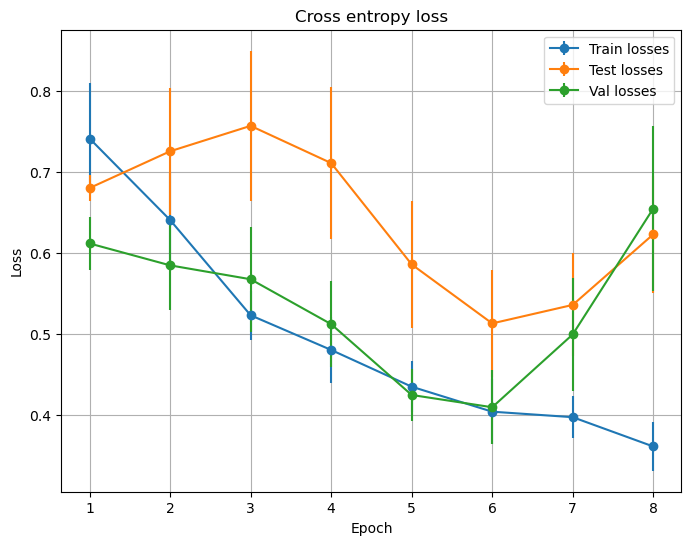

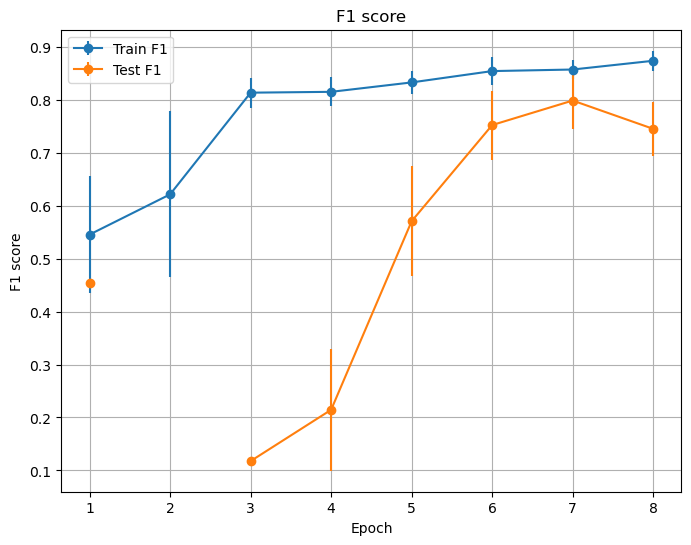

In [8]:
y_test_true, test_pred, ihb_old_real_f1 = conduct_experiments(data, labels)

In [9]:
"""
id_failed = np.where([y_test_true!=test_pred])[1]
id_ok = np.where([y_test_true==test_pred])[1]
ok_zeros = id_ok[y_test_true[id_ok] == 0]
ok_ones = id_ok[y_test_true[id_ok] == 1]

failed_zeros = id_failed[y_test_true[id_failed] == 0] # y_test_true = 0 but test_pred = 1
failed_ones = id_failed[y_test_true[id_failed] == 1] # y_test_true = 1 but test_pred = 0
print("ok_zeros indices:", ok_zeros)
print("ok_ones indices:", ok_ones)
print("failed_zeros indices:", failed_zeros)
print("failed_ones indices:", failed_ones)

data_reshaped = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
"""

'\nid_failed = np.where([y_test_true!=test_pred])[1]\nid_ok = np.where([y_test_true==test_pred])[1]\nok_zeros = id_ok[y_test_true[id_ok] == 0]\nok_ones = id_ok[y_test_true[id_ok] == 1]\n\nfailed_zeros = id_failed[y_test_true[id_failed] == 0] # y_test_true = 0 but test_pred = 1\nfailed_ones = id_failed[y_test_true[id_failed] == 1] # y_test_true = 1 but test_pred = 0\nprint("ok_zeros indices:", ok_zeros)\nprint("ok_ones indices:", ok_ones)\nprint("failed_zeros indices:", failed_zeros)\nprint("failed_ones indices:", failed_ones)\n\ndata_reshaped = data.reshape((data.shape[0], data.shape[2], data.shape[1]))\n'

In [10]:
"""
n_ok = 3
n_failed = 2
ok_to_plot = np.random.choice(ok_zeros, size=n_ok, replace=False)
failed_to_plot = np.random.choice(failed_zeros, size=n_failed, replace=False)
to_plot = np.concatenate([ok_to_plot, failed_to_plot])
nets = np.zeros(to_plot.shape)
colors = ["black"] * ok_to_plot.shape[0] + ["red"] * failed_to_plot.shape[0]
plot(data_reshaped, to_plot, nets, colors, "Net 0 ok (black) vs failed (red)")
"""

'\nn_ok = 3\nn_failed = 2\nok_to_plot = np.random.choice(ok_zeros, size=n_ok, replace=False)\nfailed_to_plot = np.random.choice(failed_zeros, size=n_failed, replace=False)\nto_plot = np.concatenate([ok_to_plot, failed_to_plot])\nnets = np.zeros(to_plot.shape)\ncolors = ["black"] * ok_to_plot.shape[0] + ["red"] * failed_to_plot.shape[0]\nplot(data_reshaped, to_plot, nets, colors, "Net 0 ok (black) vs failed (red)")\n'

In [11]:
"""
n_to_plot = 5
to_plot = np.random.choice(ok_ones, size=n_to_plot, replace=False)
nets = np.zeros(to_plot.shape)
colors = ["black", "red", "green", "blue", "purple"]
plot(data_reshaped, to_plot, nets, colors, "ok_ones")
"""

'\nn_to_plot = 5\nto_plot = np.random.choice(ok_ones, size=n_to_plot, replace=False)\nnets = np.zeros(to_plot.shape)\ncolors = ["black", "red", "green", "blue", "purple"]\nplot(data_reshaped, to_plot, nets, colors, "ok_ones")\n'

In [12]:
"""
n_to_plot = ok_zeros.shape[0]
to_plot = np.random.choice(ok_zeros, size=n_to_plot, replace=False)
nets = np.zeros(to_plot.shape)
colors = ["black", "red", "blue", "green", "purple", "magenta", "yellow", "cyan"]
plot(data_reshaped, to_plot, nets, colors, "ok_zeros")
"""

'\nn_to_plot = ok_zeros.shape[0]\nto_plot = np.random.choice(ok_zeros, size=n_to_plot, replace=False)\nnets = np.zeros(to_plot.shape)\ncolors = ["black", "red", "blue", "green", "purple", "magenta", "yellow", "cyan"]\nplot(data_reshaped, to_plot, nets, colors, "ok_zeros")\n'

In [13]:
#failed_zeros.shape[0]

In [14]:
"""n_to_plot = failed_zeros.shape[0]
to_plot = np.random.choice(failed_zeros, size=n_to_plot, replace=False)
nets = np.zeros(to_plot.shape)
colors = ["black", "red", "blue", "green", "purple", "magenta", "yellow", "cyan", "pink"]
plot(data_reshaped, to_plot, nets, colors, "failed_zeros")
"""

'n_to_plot = failed_zeros.shape[0]\nto_plot = np.random.choice(failed_zeros, size=n_to_plot, replace=False)\nnets = np.zeros(to_plot.shape)\ncolors = ["black", "red", "blue", "green", "purple", "magenta", "yellow", "cyan", "pink"]\nplot(data_reshaped, to_plot, nets, colors, "failed_zeros")\n'

In [15]:
augmented_data = torch.load("fmri_old/aug_data_ihb.pt")

In [16]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

Epoch 1/8, Train loss: 0.6456, Test loss: 0.6954
Epoch 1/8, Train loss: 1.0257, Test loss: 0.6821
Epoch 1/8, Train loss: 0.7683, Test loss: 0.6676
Epoch 1/8, Train loss: 0.6126, Test loss: 0.7271
Epoch 1/8, Train loss: 0.7001, Test loss: 0.6668
Epoch 1/8, Train loss: 0.6587, Test loss: 0.6633
Epoch 1/8, Train loss: 0.6880, Test loss: 0.7080
Epoch 1/8, Train loss: 0.5927, Test loss: 0.7088
Epoch 1/8, Train loss: 0.7986, Test loss: 0.6990
Epoch 1/8, Train loss: 0.6665, Test loss: 0.6596
Epoch 1/8, Train loss: 0.7454, Test loss: 0.6772
Epoch 1/8, Train loss: 0.9132, Test loss: 0.6796
Epoch 1/8, Train loss: 0.8289, Test loss: 0.6856
Epoch 1/8, Train loss: 0.8188, Test loss: 0.6774
Epoch 1/8, Train loss: 0.6912, Test loss: 0.6593


/home/sbzhukhlistov/plot_functions.py:26: RuntimeWarning: Mean of empty slice
  test_f1_mean = np.nanmean(test_f1_np, axis=0)
/home/sbzhukhlistov/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


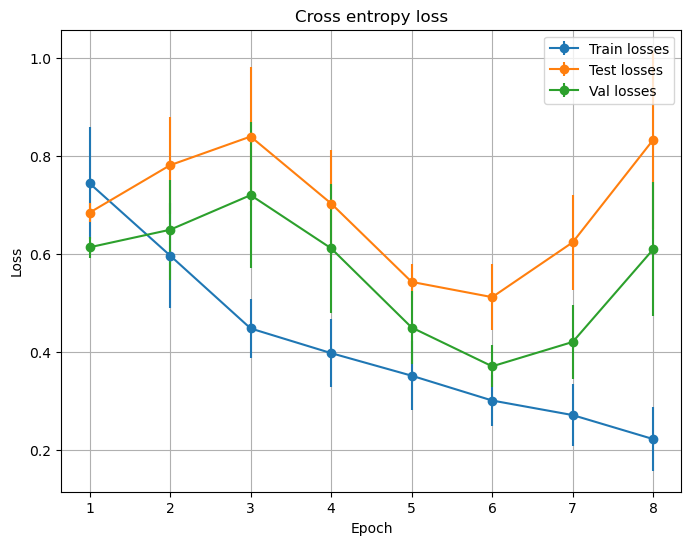

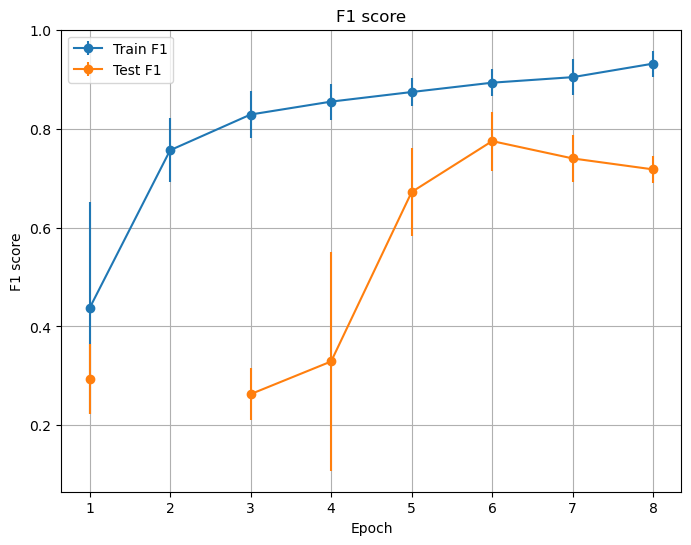

In [17]:
ihb_old_aug_f1 = conduct_experiments_aug(data, augmented_data, labels, aug_labels)

In [18]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

Epoch 1/8, Train loss: 0.7124, Test loss: 0.6329
Epoch 1/8, Train loss: 0.9567, Test loss: 0.6845
Epoch 1/8, Train loss: 0.6159, Test loss: 0.8842
Epoch 1/8, Train loss: 0.7656, Test loss: 0.7669
Epoch 1/8, Train loss: 0.7110, Test loss: 0.7114
Epoch 1/8, Train loss: 0.7489, Test loss: 0.7265
Epoch 1/8, Train loss: 0.7472, Test loss: 0.7275
Epoch 1/8, Train loss: 0.6105, Test loss: 0.7623
Epoch 1/8, Train loss: 0.5946, Test loss: 0.9739
Epoch 1/8, Train loss: 1.0278, Test loss: 0.6489
Epoch 1/8, Train loss: 0.8274, Test loss: 0.7849
Epoch 1/8, Train loss: 0.6821, Test loss: 0.6912
Epoch 1/8, Train loss: 0.6068, Test loss: 0.7286
Epoch 1/8, Train loss: 0.7291, Test loss: 0.7809
Epoch 1/8, Train loss: 0.6813, Test loss: 0.6981


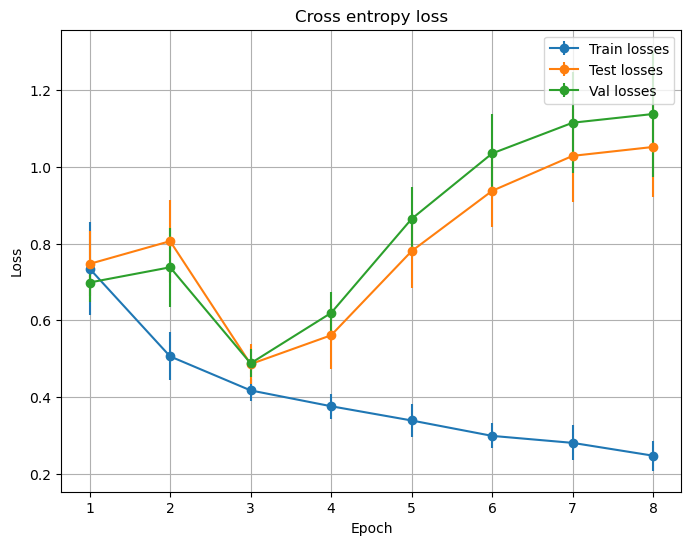

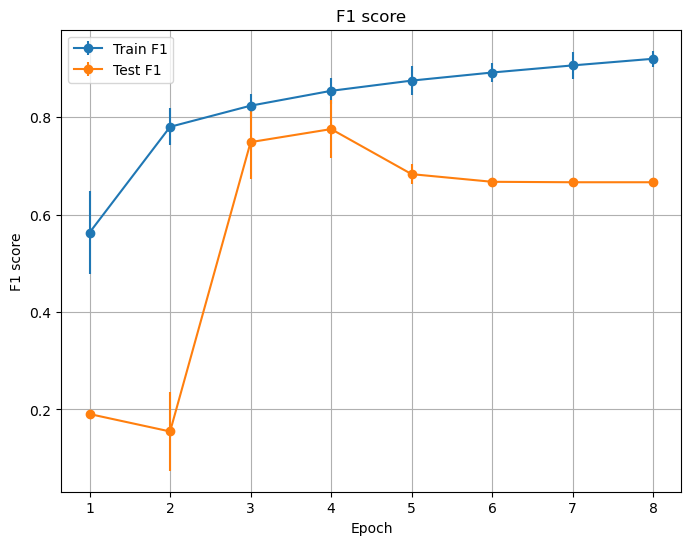

In [19]:
ihb_old_comb_f1 = conduct_experiments_aug(data, combined_data, labels, combined_labels)

## IHB new

In [20]:
dataset_name = "ihb"
close, open, data = load_data(dataset_name, old=False)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

Epoch 1/8, Train loss: 0.7727, Test loss: 0.7108
Epoch 1/8, Train loss: 0.7083, Test loss: 0.6957
Epoch 1/8, Train loss: 0.8234, Test loss: 0.7019
Epoch 1/8, Train loss: 1.0705, Test loss: 0.6977
Epoch 1/8, Train loss: 1.5540, Test loss: 0.7406
Epoch 1/8, Train loss: 0.7766, Test loss: 0.6946
Epoch 1/8, Train loss: 0.6740, Test loss: 0.7334
Epoch 1/8, Train loss: 1.1466, Test loss: 0.6929
Epoch 1/8, Train loss: 0.8220, Test loss: 0.6940
Epoch 1/8, Train loss: 0.7720, Test loss: 0.7365
Epoch 1/8, Train loss: 0.7537, Test loss: 0.6976
Epoch 1/8, Train loss: 0.9062, Test loss: 0.6929
Epoch 1/8, Train loss: 0.9198, Test loss: 0.6997
Epoch 1/8, Train loss: 0.7148, Test loss: 0.6864
Epoch 1/8, Train loss: 0.7151, Test loss: 0.6990


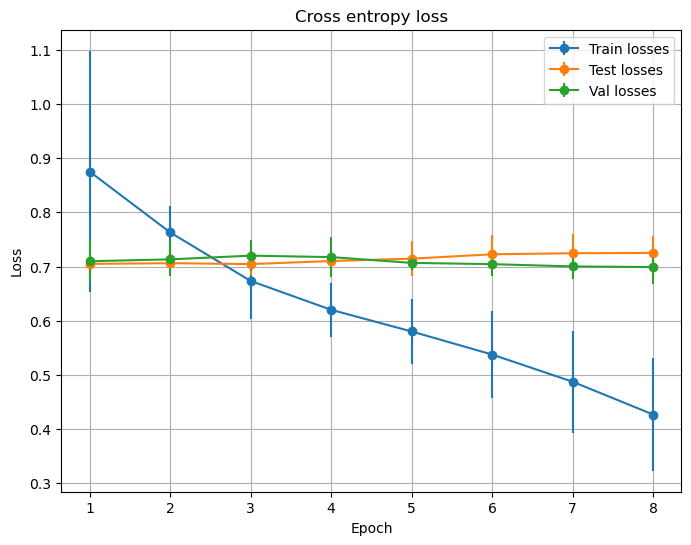

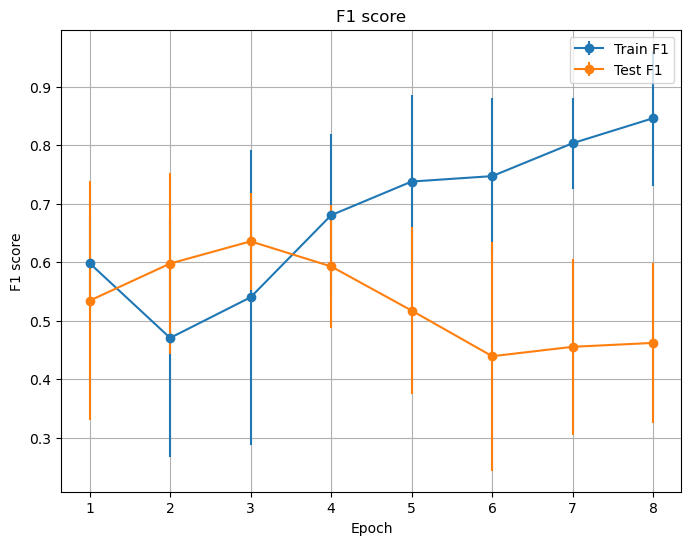

In [21]:
_, _, ihb_new_real_f1 = conduct_experiments(data, labels)

In [22]:
augmented_data = torch.load("fmri/aug_data_ihb.pt")

In [23]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

Epoch 1/8, Train loss: 0.7975, Test loss: 0.7184
Epoch 1/8, Train loss: 0.8879, Test loss: 0.6985
Epoch 1/8, Train loss: 0.7421, Test loss: 0.6996
Epoch 1/8, Train loss: 0.8491, Test loss: 0.7023
Epoch 1/8, Train loss: 0.8634, Test loss: 0.6958
Epoch 1/8, Train loss: 0.9230, Test loss: 0.7002
Epoch 1/8, Train loss: 0.6848, Test loss: 0.6921
Epoch 1/8, Train loss: 0.8284, Test loss: 0.7189
Epoch 1/8, Train loss: 0.8237, Test loss: 0.7059
Epoch 1/8, Train loss: 0.8757, Test loss: 0.6946
Epoch 1/8, Train loss: 0.9206, Test loss: 0.6978
Epoch 1/8, Train loss: 1.0521, Test loss: 0.6934
Epoch 1/8, Train loss: 0.9906, Test loss: 0.6925
Epoch 1/8, Train loss: 0.8033, Test loss: 0.7114
Epoch 1/8, Train loss: 0.8300, Test loss: 0.6915


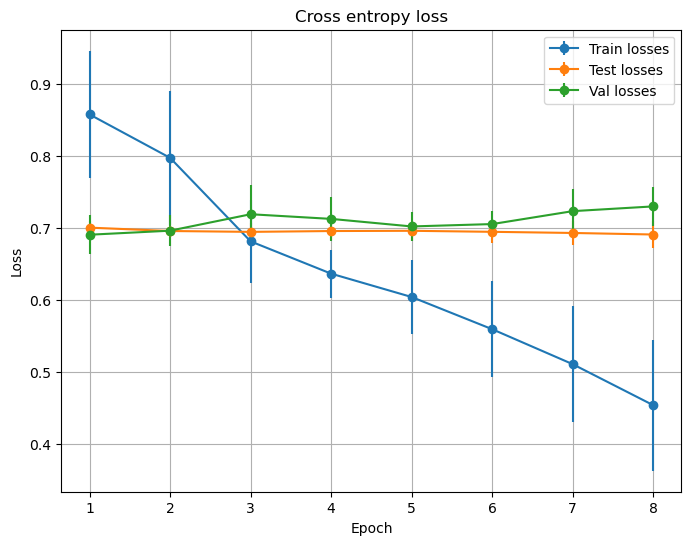

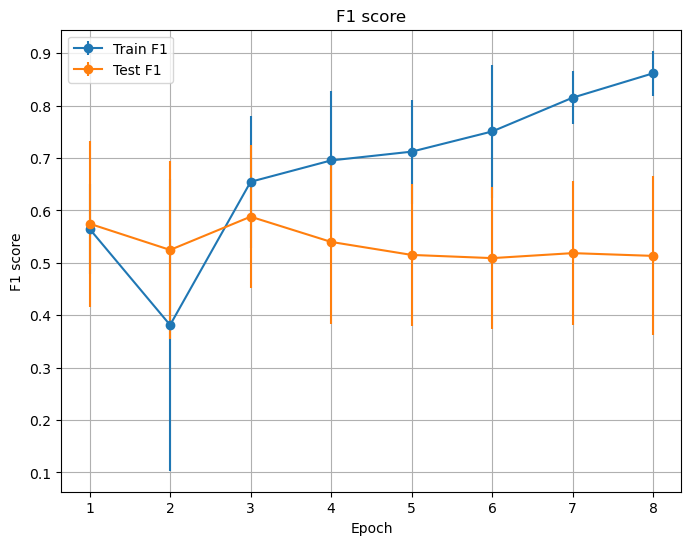

In [24]:
ihb_new_aug_f1 = conduct_experiments_aug(data, augmented_data, labels, aug_labels)

In [25]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

Epoch 1/8, Train loss: 0.8698, Test loss: 0.6922
Epoch 1/8, Train loss: 0.8969, Test loss: 0.7056
Epoch 1/8, Train loss: 1.0245, Test loss: 0.7117
Epoch 1/8, Train loss: 1.0626, Test loss: 0.6991
Epoch 1/8, Train loss: 0.8827, Test loss: 0.7216
Epoch 1/8, Train loss: 0.8866, Test loss: 0.6989
Epoch 1/8, Train loss: 0.7597, Test loss: 0.7310
Epoch 1/8, Train loss: 0.8559, Test loss: 0.6924
Epoch 1/8, Train loss: 0.8362, Test loss: 0.6821
Epoch 1/8, Train loss: 0.7413, Test loss: 0.6909
Epoch 1/8, Train loss: 0.8734, Test loss: 0.6974
Epoch 1/8, Train loss: 0.8013, Test loss: 0.7806
Epoch 1/8, Train loss: 0.8268, Test loss: 0.6909
Epoch 1/8, Train loss: 1.0362, Test loss: 0.6910
Epoch 1/8, Train loss: 0.8026, Test loss: 0.7222


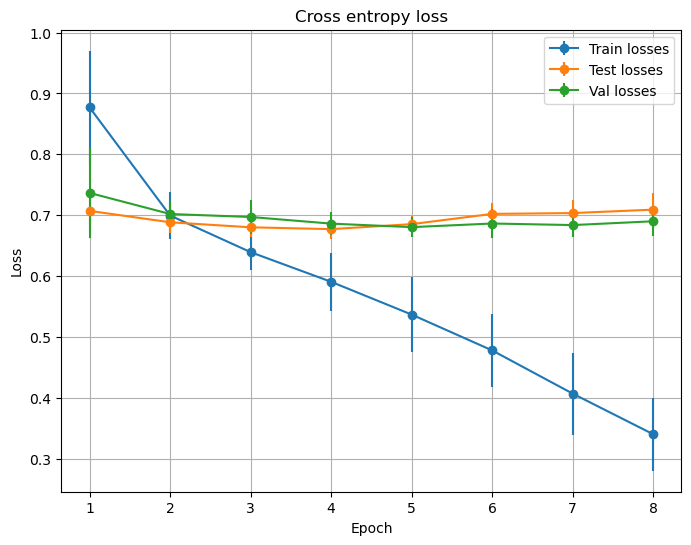

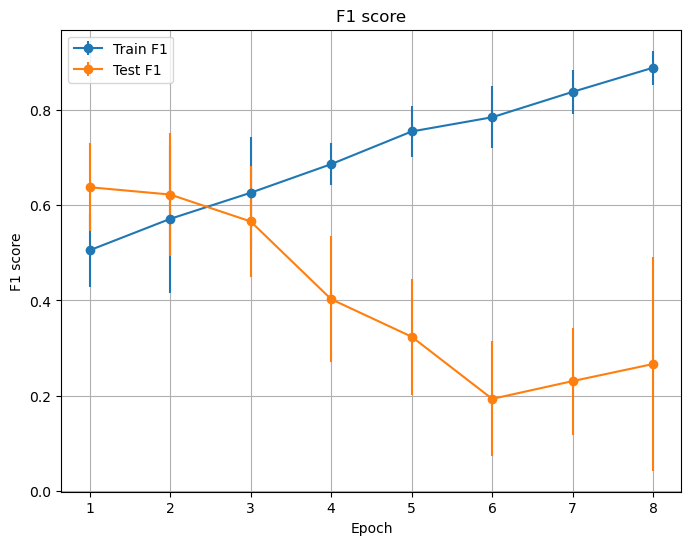

In [26]:
ihb_new_comb_f1 = conduct_experiments_aug(data, combined_data, labels, combined_labels)

## Результаты IHB

/home/sbzhukhlistov/plot_functions.py:70: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values, axis=0)
/home/sbzhukhlistov/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


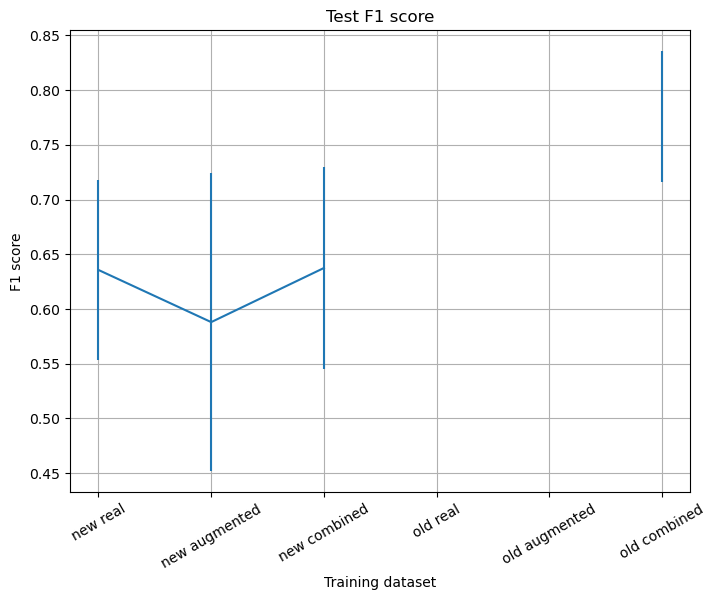

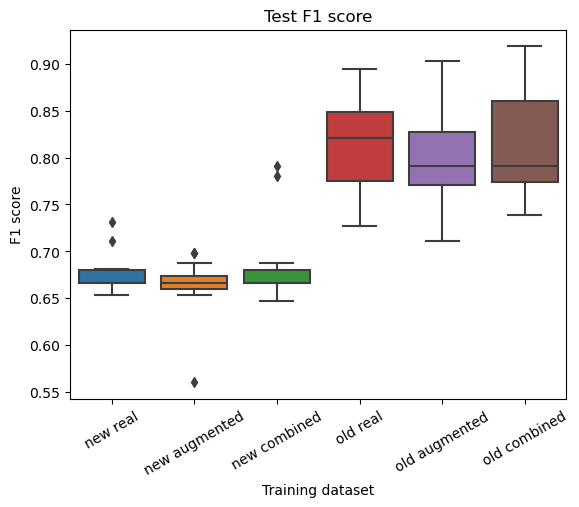

In [27]:
plot_results(ihb_new_real_f1, ihb_new_aug_f1, ihb_new_comb_f1, ihb_old_real_f1, ihb_old_aug_f1, ihb_old_comb_f1)

## China old

In [28]:
dataset_name = "china"
close, open, data = load_data(dataset_name, old=True)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

Epoch 1/8, Train loss: 1.3785, Test loss: 0.6575
Epoch 1/8, Train loss: 2.0113, Test loss: 0.6435
Epoch 1/8, Train loss: 1.1372, Test loss: 0.6305
Epoch 1/8, Train loss: 1.0582, Test loss: 0.6284
Epoch 1/8, Train loss: 2.1736, Test loss: 0.6245
Epoch 1/8, Train loss: 7.0813, Test loss: 0.9071
Epoch 1/8, Train loss: 2.0786, Test loss: 0.6300
Epoch 1/8, Train loss: 2.1205, Test loss: 0.6509
Epoch 1/8, Train loss: 1.4322, Test loss: 0.6309
Epoch 1/8, Train loss: 2.1789, Test loss: 0.6531
Epoch 1/8, Train loss: 5.3172, Test loss: 0.7604
Epoch 1/8, Train loss: 2.5561, Test loss: 0.7060
Epoch 1/8, Train loss: 3.2963, Test loss: 0.9046
Epoch 1/8, Train loss: 1.7402, Test loss: 0.6546
Epoch 1/8, Train loss: 3.8659, Test loss: 0.6416


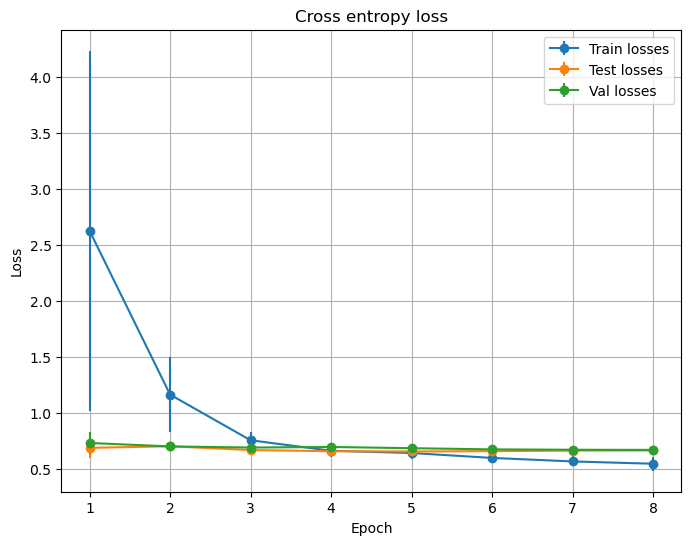

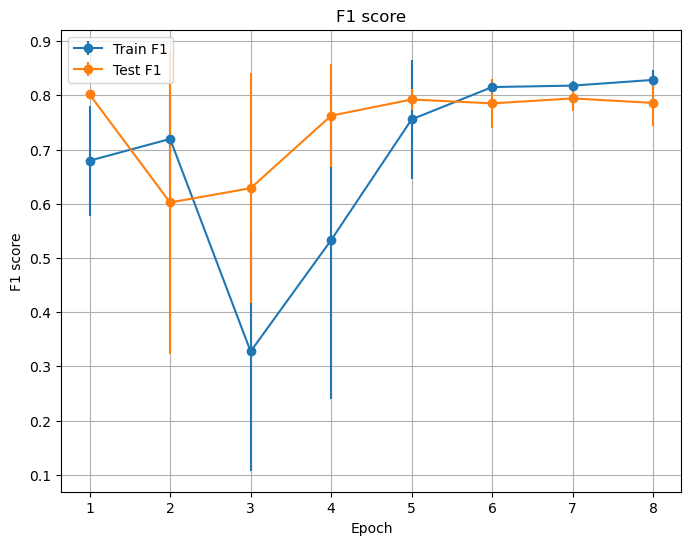

In [29]:
_, _, china_old_real_f1 = conduct_experiments(data, labels, conv_output_size=2912)

In [30]:
augmented_data = torch.load("fmri_old/aug_data_china.pt")

In [31]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

Epoch 1/8, Train loss: 2.6771, Test loss: 0.7132
Epoch 1/8, Train loss: 5.1600, Test loss: 0.7119
Epoch 1/8, Train loss: 3.7789, Test loss: 0.6938
Epoch 1/8, Train loss: 1.6924, Test loss: 0.6446
Epoch 1/8, Train loss: 1.1307, Test loss: 0.6847
Epoch 1/8, Train loss: 0.7986, Test loss: 0.6938
Epoch 1/8, Train loss: 1.4221, Test loss: 0.6974
Epoch 1/8, Train loss: 1.4882, Test loss: 0.6635
Epoch 1/8, Train loss: 1.7278, Test loss: 0.6312
Epoch 1/8, Train loss: 2.7663, Test loss: 0.6446
Epoch 1/8, Train loss: 1.7487, Test loss: 0.6821
Epoch 1/8, Train loss: 1.8495, Test loss: 0.6420
Epoch 1/8, Train loss: 2.5961, Test loss: 0.6537
Epoch 1/8, Train loss: 3.6487, Test loss: 0.6589
Epoch 1/8, Train loss: 2.0583, Test loss: 0.6316


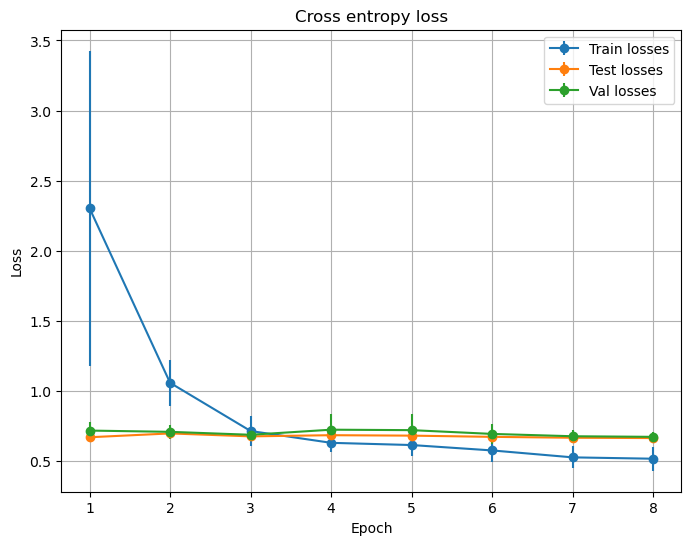

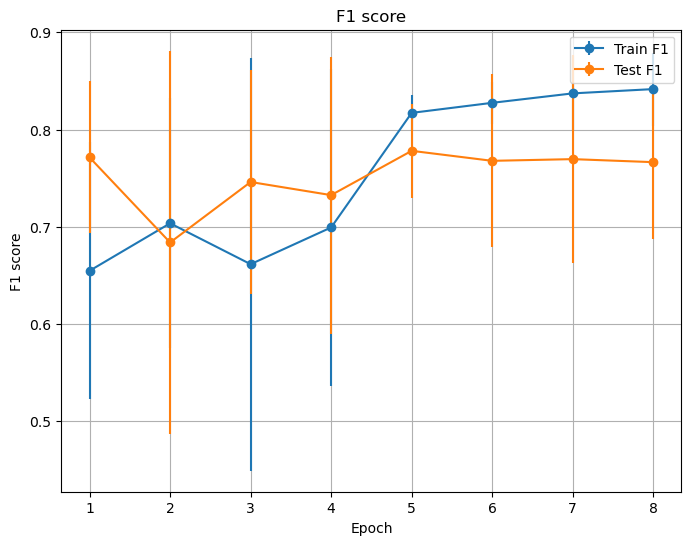

In [32]:
china_old_aug_f1 = conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=2912)

In [33]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

Epoch 1/8, Train loss: 1.4222, Test loss: 0.7246
Epoch 1/8, Train loss: 1.4619, Test loss: 0.7808
Epoch 1/8, Train loss: 1.0175, Test loss: 0.6320
Epoch 1/8, Train loss: 1.6941, Test loss: 0.7019
Epoch 1/8, Train loss: 1.5966, Test loss: 0.7578
Epoch 1/8, Train loss: 1.3474, Test loss: 0.6689
Epoch 1/8, Train loss: 5.4193, Test loss: 0.6709
Epoch 1/8, Train loss: 1.4290, Test loss: 0.7635
Epoch 1/8, Train loss: 1.3970, Test loss: 0.7426
Epoch 1/8, Train loss: 1.3591, Test loss: 0.6824
Epoch 1/8, Train loss: 3.2653, Test loss: 0.8040
Epoch 1/8, Train loss: 1.4863, Test loss: 0.7346
Epoch 1/8, Train loss: 3.5236, Test loss: 0.6656
Epoch 1/8, Train loss: 1.7214, Test loss: 0.6855
Epoch 1/8, Train loss: 1.3091, Test loss: 0.7534


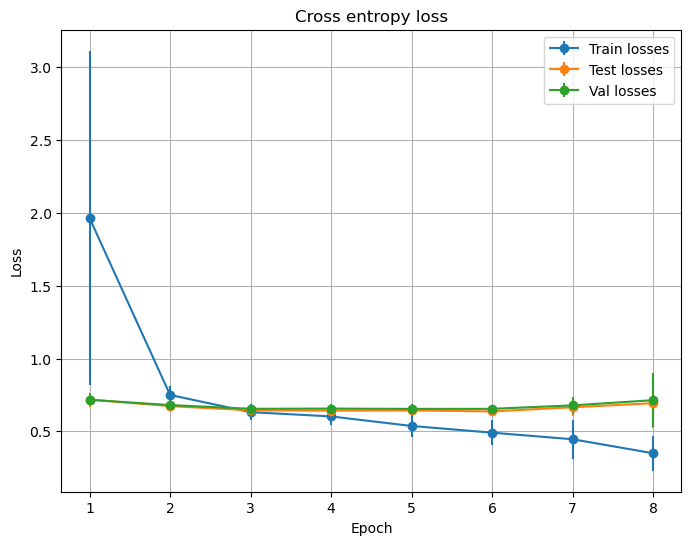

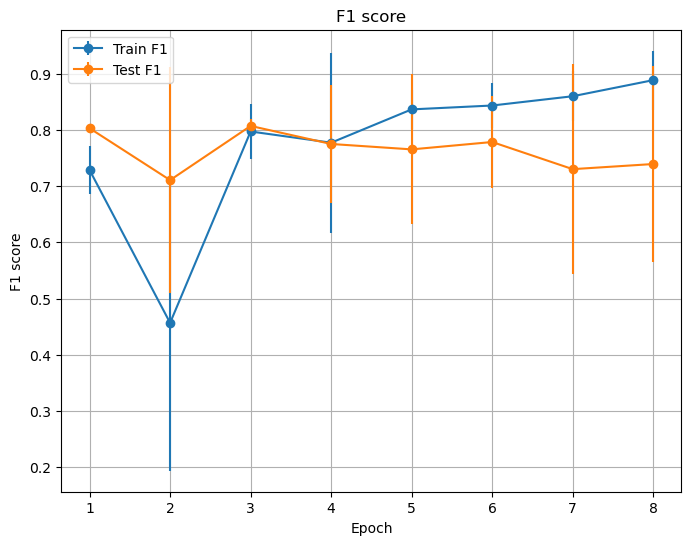

In [34]:
china_old_comb_f1 = conduct_experiments_aug(data, combined_data, labels, combined_labels, conv_output_size=2912)

## China new

In [35]:
dataset_name = "china"
close, open, data = load_data(dataset_name, old=False)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

Epoch 1/8, Train loss: 0.7486, Test loss: 0.6420
Epoch 1/8, Train loss: 5.6298, Test loss: 0.7182
Epoch 1/8, Train loss: 2.6454, Test loss: 0.6312
Epoch 1/8, Train loss: 1.1170, Test loss: 0.6395
Epoch 1/8, Train loss: 4.9844, Test loss: 0.6093
Epoch 1/8, Train loss: 1.1120, Test loss: 0.6738
Epoch 1/8, Train loss: 1.5704, Test loss: 0.6444
Epoch 1/8, Train loss: 2.2235, Test loss: 0.6345
Epoch 1/8, Train loss: 4.5158, Test loss: 0.6695
Epoch 1/8, Train loss: 1.5282, Test loss: 0.6316
Epoch 1/8, Train loss: 0.9829, Test loss: 0.6706
Epoch 1/8, Train loss: 1.8318, Test loss: 0.6367
Epoch 1/8, Train loss: 1.5221, Test loss: 0.6481
Epoch 1/8, Train loss: 2.9516, Test loss: 0.6576
Epoch 1/8, Train loss: 1.9046, Test loss: 0.6238


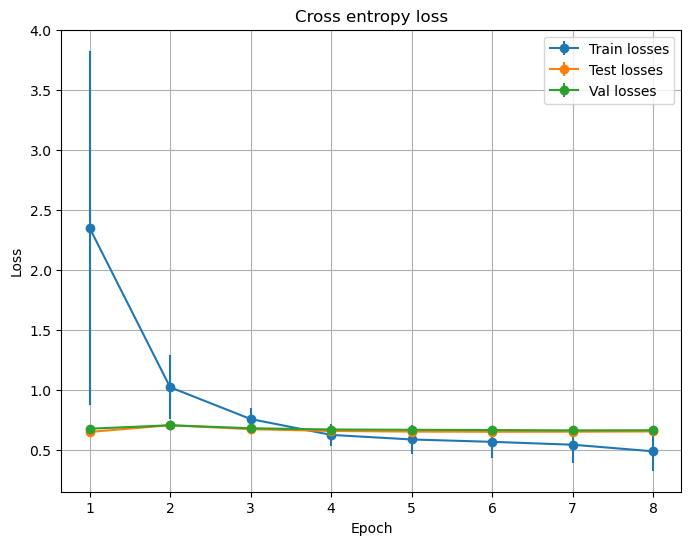

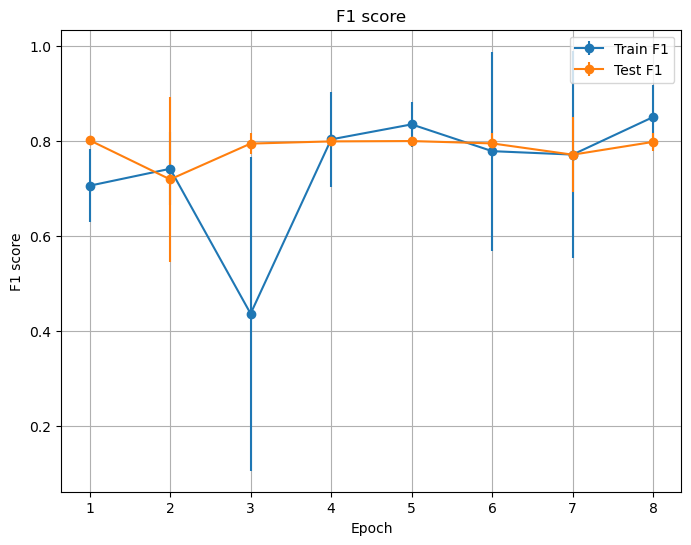

In [36]:
_, _, china_new_real_f1 = conduct_experiments(data, labels, conv_output_size=2912)

In [37]:
augmented_data = torch.load("fmri/aug_data_china.pt")

In [38]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

Epoch 1/8, Train loss: 6.0415, Test loss: 0.6618
Epoch 1/8, Train loss: 3.6797, Test loss: 0.6403
Epoch 1/8, Train loss: 4.0157, Test loss: 0.6488
Epoch 1/8, Train loss: 1.6982, Test loss: 0.6432
Epoch 1/8, Train loss: 3.2121, Test loss: 0.6066
Epoch 1/8, Train loss: 1.0822, Test loss: 0.6351
Epoch 1/8, Train loss: 0.8779, Test loss: 0.6459
Epoch 1/8, Train loss: 2.7812, Test loss: 0.6365
Epoch 1/8, Train loss: 5.4933, Test loss: 0.6459
Epoch 1/8, Train loss: 1.8720, Test loss: 0.6353
Epoch 1/8, Train loss: 1.8395, Test loss: 0.6608
Epoch 1/8, Train loss: 4.1482, Test loss: 0.6449
Epoch 1/8, Train loss: 1.9391, Test loss: 0.6380
Epoch 1/8, Train loss: 1.7202, Test loss: 0.6542
Epoch 1/8, Train loss: 1.8335, Test loss: 0.6485


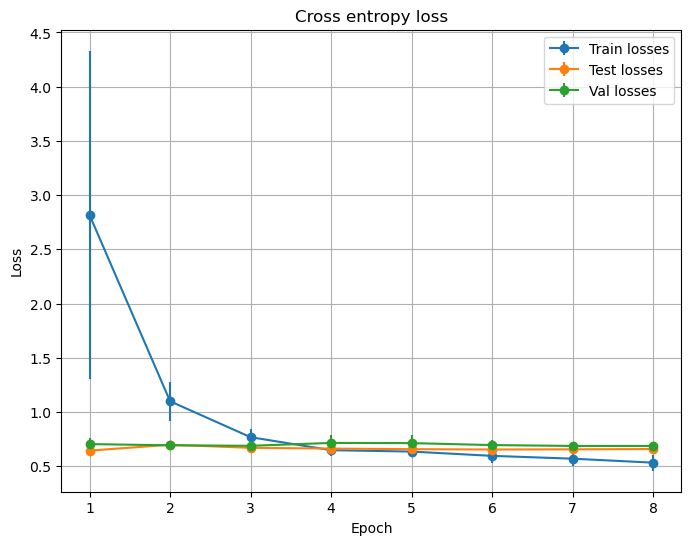

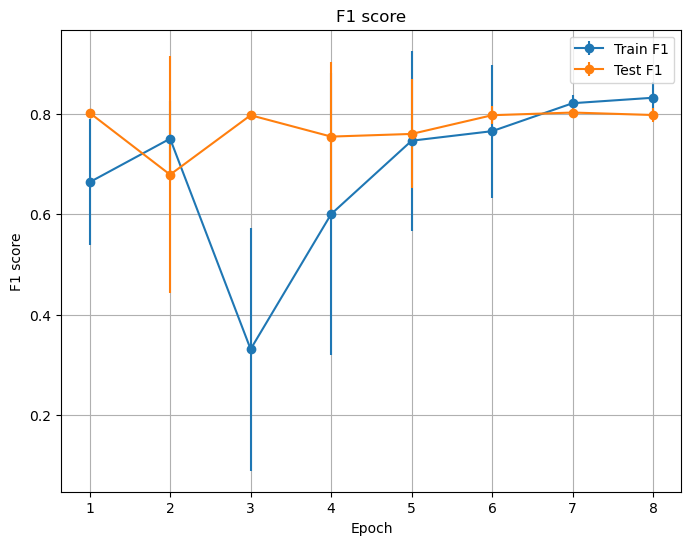

In [39]:
china_new_aug_f1 = conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=2912)

In [40]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

Epoch 1/8, Train loss: 1.2621, Test loss: 0.6853
Epoch 1/8, Train loss: 1.6410, Test loss: 0.9564
Epoch 1/8, Train loss: 1.6163, Test loss: 0.6864
Epoch 1/8, Train loss: 1.7780, Test loss: 0.7166
Epoch 1/8, Train loss: 1.3067, Test loss: 0.8619
Epoch 1/8, Train loss: 1.7664, Test loss: 0.7105
Epoch 1/8, Train loss: 1.2445, Test loss: 0.7786
Epoch 1/8, Train loss: 1.7869, Test loss: 0.7349
Epoch 1/8, Train loss: 1.8317, Test loss: 0.7218
Epoch 1/8, Train loss: 2.7017, Test loss: 0.9211
Epoch 1/8, Train loss: 1.3605, Test loss: 0.7417
Epoch 1/8, Train loss: 0.9468, Test loss: 0.6491
Epoch 1/8, Train loss: 1.6526, Test loss: 0.7359
Epoch 1/8, Train loss: 1.2759, Test loss: 0.6360
Epoch 1/8, Train loss: 1.6141, Test loss: 0.7007


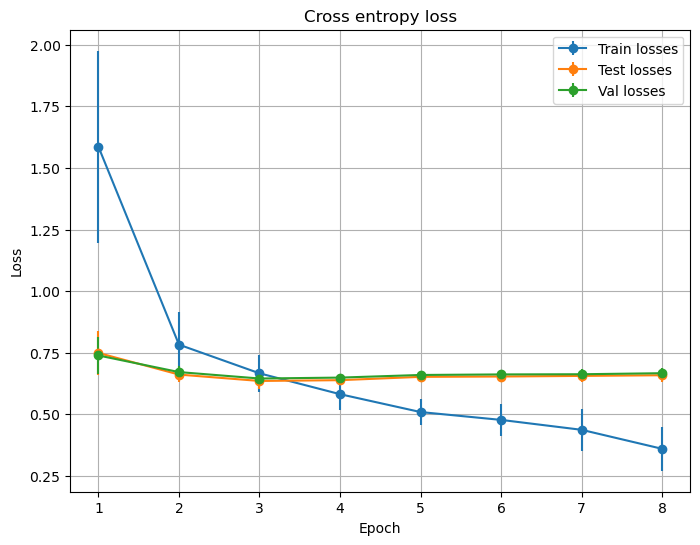

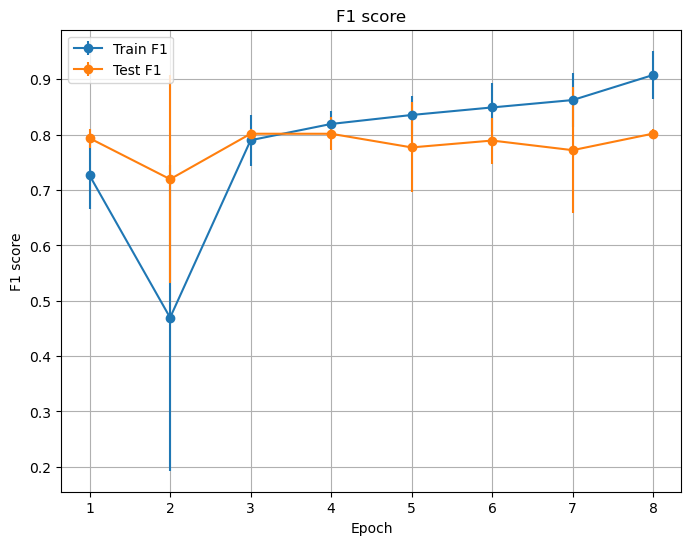

In [41]:
china_new_comb_f1 = conduct_experiments_aug(data, combined_data, labels, combined_labels, conv_output_size=2912)

## Результаты China

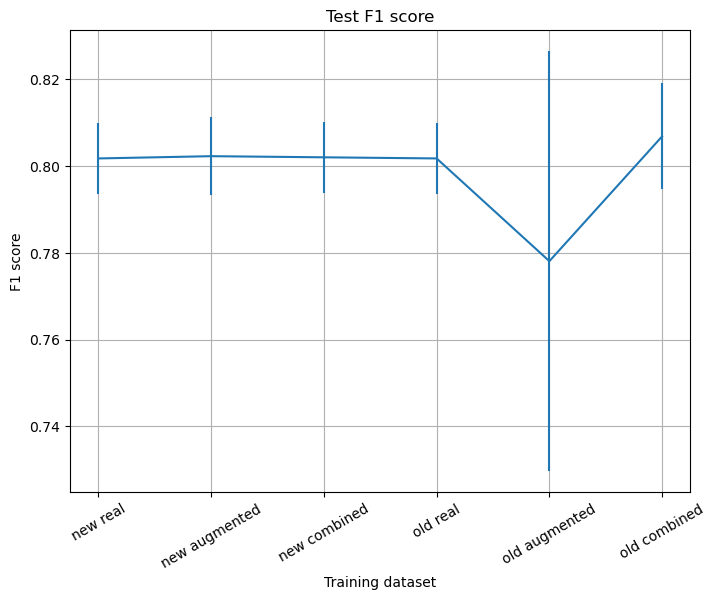

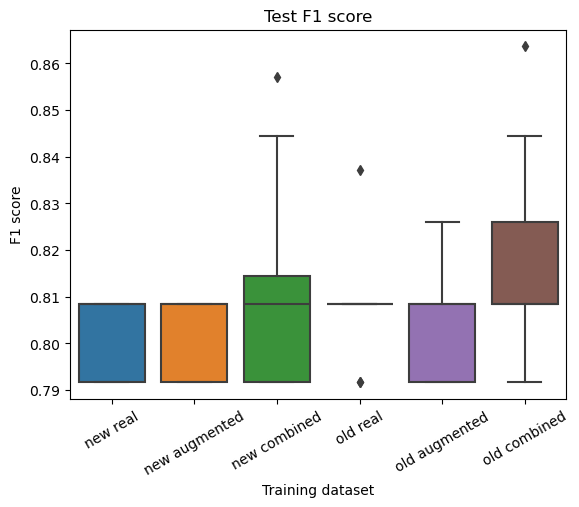

In [42]:
plot_results(china_new_real_f1, china_new_aug_f1, china_new_comb_f1, china_old_real_f1, china_old_aug_f1, china_old_comb_f1)

## China cut old

In [43]:
dataset_name = "china_cut"
close, open, data = load_data(dataset_name, old=True)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

Epoch 1/8, Train loss: 0.9672, Test loss: 0.6884
Epoch 1/8, Train loss: 1.4798, Test loss: 0.6743
Epoch 1/8, Train loss: 0.7374, Test loss: 0.7017
Epoch 1/8, Train loss: 3.5224, Test loss: 0.6950
Epoch 1/8, Train loss: 0.8904, Test loss: 0.6952
Epoch 1/8, Train loss: 0.7853, Test loss: 0.6900
Epoch 1/8, Train loss: 1.7444, Test loss: 0.6879
Epoch 1/8, Train loss: 0.8189, Test loss: 0.6833
Epoch 1/8, Train loss: 0.9439, Test loss: 0.7086
Epoch 1/8, Train loss: 0.8195, Test loss: 0.7211
Epoch 1/8, Train loss: 0.9512, Test loss: 0.7100
Epoch 1/8, Train loss: 0.6479, Test loss: 0.7374
Epoch 1/8, Train loss: 1.0734, Test loss: 0.7164
Epoch 1/8, Train loss: 1.2622, Test loss: 0.7314
Epoch 1/8, Train loss: 2.6746, Test loss: 0.6855


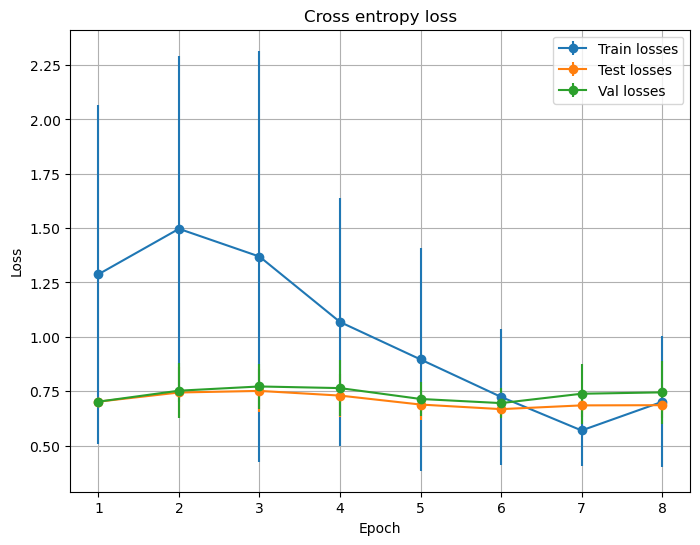

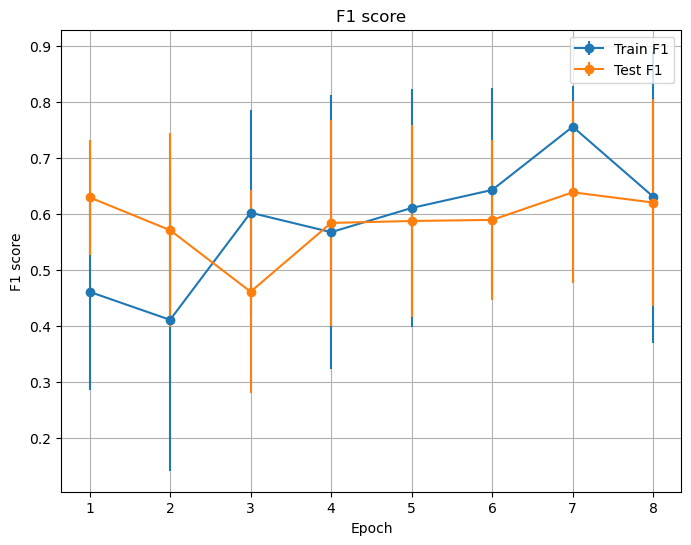

In [44]:
_, _, china_cut_old_real_f1 = conduct_experiments(data, labels, conv_output_size=2912)

In [45]:
augmented_data = torch.load("fmri_old/aug_data_china_cut.pt")

In [46]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

Epoch 1/8, Train loss: 0.7841, Test loss: 0.6833
Epoch 1/8, Train loss: 2.4962, Test loss: 0.7186
Epoch 1/8, Train loss: 0.6755, Test loss: 0.7287
Epoch 1/8, Train loss: 1.6357, Test loss: 0.6895
Epoch 1/8, Train loss: 2.6826, Test loss: 0.7443
Epoch 1/8, Train loss: 2.0609, Test loss: 0.7153
Epoch 1/8, Train loss: 1.6836, Test loss: 0.7091
Epoch 1/8, Train loss: 1.2391, Test loss: 0.6976
Epoch 1/8, Train loss: 0.5697, Test loss: 0.8004
Epoch 1/8, Train loss: 1.1210, Test loss: 0.6954
Epoch 1/8, Train loss: 0.8202, Test loss: 0.7058
Epoch 1/8, Train loss: 0.7050, Test loss: 0.7063
Epoch 1/8, Train loss: 1.3119, Test loss: 0.7062
Epoch 1/8, Train loss: 0.5160, Test loss: 0.8122
Epoch 1/8, Train loss: 1.0105, Test loss: 0.6881


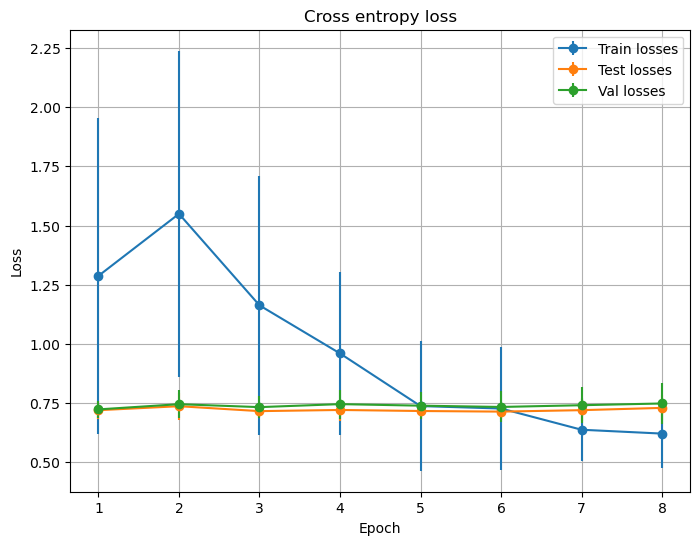

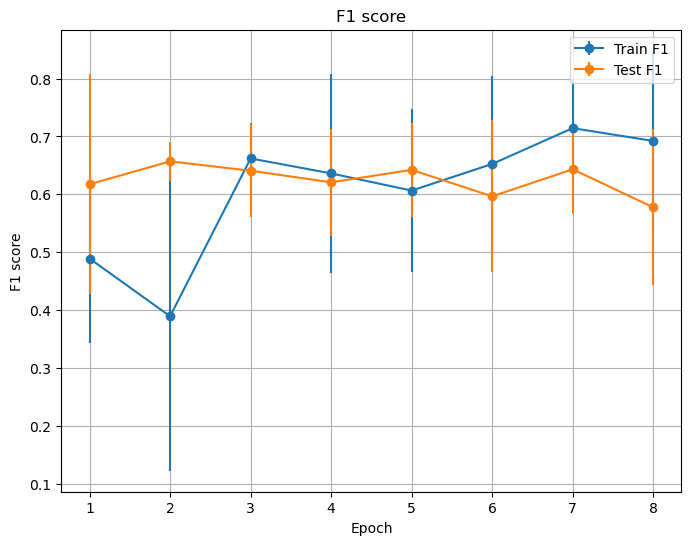

In [47]:
china_cut_old_aug_f1 = conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=2912)

In [48]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

Epoch 1/8, Train loss: 2.3302, Test loss: 0.6927
Epoch 1/8, Train loss: 0.8541, Test loss: 1.0310
Epoch 1/8, Train loss: 1.4119, Test loss: 0.9373
Epoch 1/8, Train loss: 1.5011, Test loss: 0.7912
Epoch 1/8, Train loss: 1.5382, Test loss: 0.6930
Epoch 1/8, Train loss: 1.6347, Test loss: 0.7477
Epoch 1/8, Train loss: 1.3587, Test loss: 0.7618
Epoch 1/8, Train loss: 0.9107, Test loss: 0.6659
Epoch 1/8, Train loss: 1.5069, Test loss: 0.7568
Epoch 1/8, Train loss: 2.1169, Test loss: 0.6902
Epoch 1/8, Train loss: 1.6754, Test loss: 0.7392
Epoch 1/8, Train loss: 1.1854, Test loss: 0.9962
Epoch 1/8, Train loss: 2.1085, Test loss: 0.6985
Epoch 1/8, Train loss: 2.3598, Test loss: 0.6830
Epoch 1/8, Train loss: 0.6162, Test loss: 0.7585


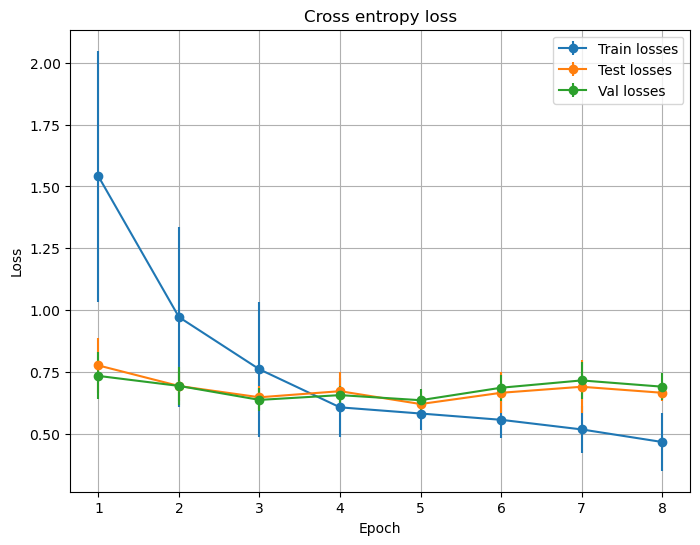

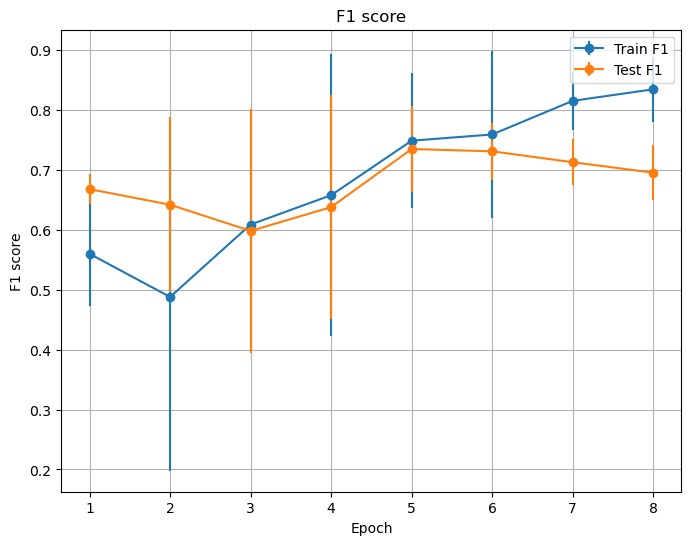

In [49]:
china_cut_old_comb_f1 = conduct_experiments_aug(data, combined_data, labels, combined_labels, conv_output_size=2912)

## China cut new

In [50]:
dataset_name = "china_cut"
close, open, data = load_data(dataset_name, old=False)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

Epoch 1/8, Train loss: 0.8076, Test loss: 0.7278
Epoch 1/8, Train loss: 0.7750, Test loss: 0.7437
Epoch 1/8, Train loss: 2.0654, Test loss: 0.6925
Epoch 1/8, Train loss: 0.8700, Test loss: 0.7446
Epoch 1/8, Train loss: 2.0726, Test loss: 0.6862
Epoch 1/8, Train loss: 0.8146, Test loss: 0.7102
Epoch 1/8, Train loss: 0.8001, Test loss: 0.7106
Epoch 1/8, Train loss: 1.6946, Test loss: 0.6972
Epoch 1/8, Train loss: 1.7280, Test loss: 0.7134
Epoch 1/8, Train loss: 0.7479, Test loss: 0.6953
Epoch 1/8, Train loss: 1.8413, Test loss: 0.6943
Epoch 1/8, Train loss: 1.0423, Test loss: 0.6948
Epoch 1/8, Train loss: 3.1351, Test loss: 0.6840
Epoch 1/8, Train loss: 0.4032, Test loss: 0.8436
Epoch 1/8, Train loss: 2.8008, Test loss: 0.6927


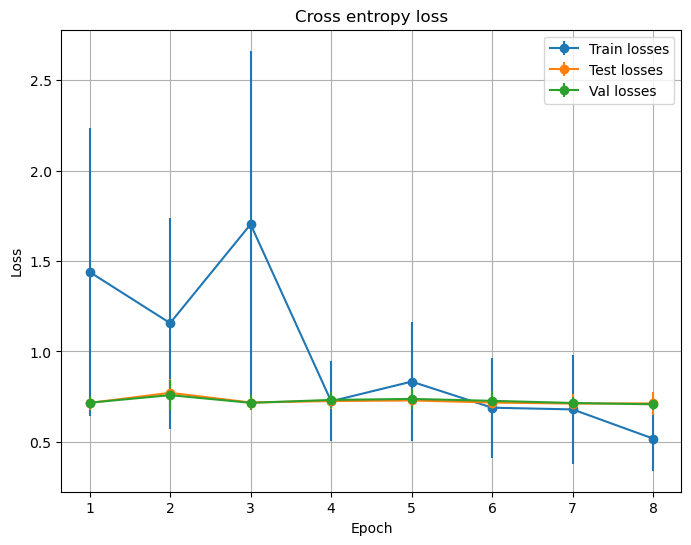

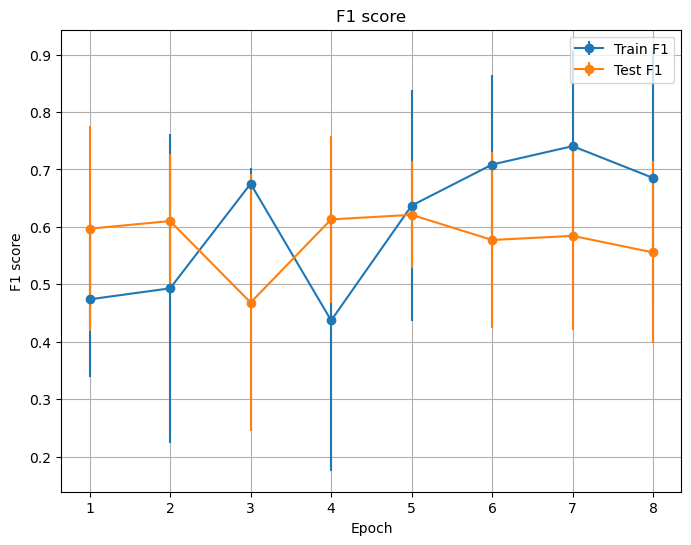

In [51]:
_, _, china_cut_new_real_f1 = conduct_experiments(data, labels, conv_output_size=2912)

In [52]:
augmented_data = torch.load("fmri/aug_data_china_cut.pt")

In [53]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

Epoch 1/8, Train loss: 1.7503, Test loss: 0.6949
Epoch 1/8, Train loss: 3.0732, Test loss: 0.6928
Epoch 1/8, Train loss: 0.3592, Test loss: 0.7719
Epoch 1/8, Train loss: 1.5716, Test loss: 0.6934
Epoch 1/8, Train loss: 0.7093, Test loss: 0.7004
Epoch 1/8, Train loss: 1.0511, Test loss: 0.6953
Epoch 1/8, Train loss: 1.0135, Test loss: 0.7181
Epoch 1/8, Train loss: 0.8277, Test loss: 0.7102
Epoch 1/8, Train loss: 1.3582, Test loss: 0.7107
Epoch 1/8, Train loss: 2.9645, Test loss: 0.6955
Epoch 1/8, Train loss: 0.4768, Test loss: 0.7750
Epoch 1/8, Train loss: 2.5085, Test loss: 0.7049
Epoch 1/8, Train loss: 1.7809, Test loss: 0.7235
Epoch 1/8, Train loss: 0.8802, Test loss: 0.7083
Epoch 1/8, Train loss: 0.7803, Test loss: 0.6944


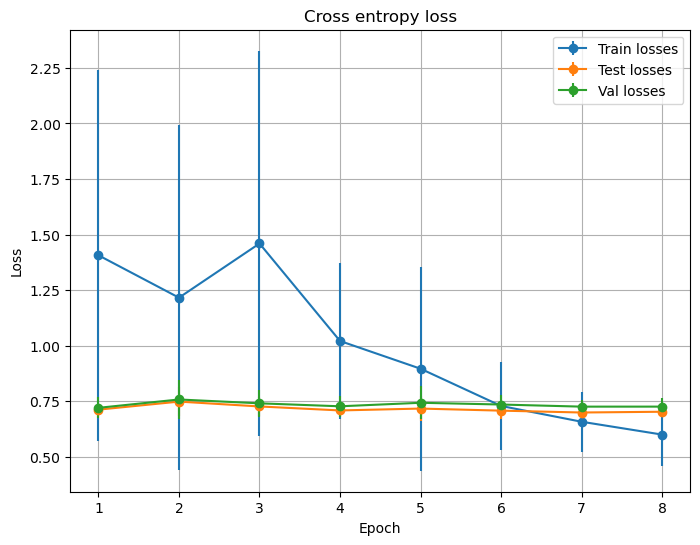

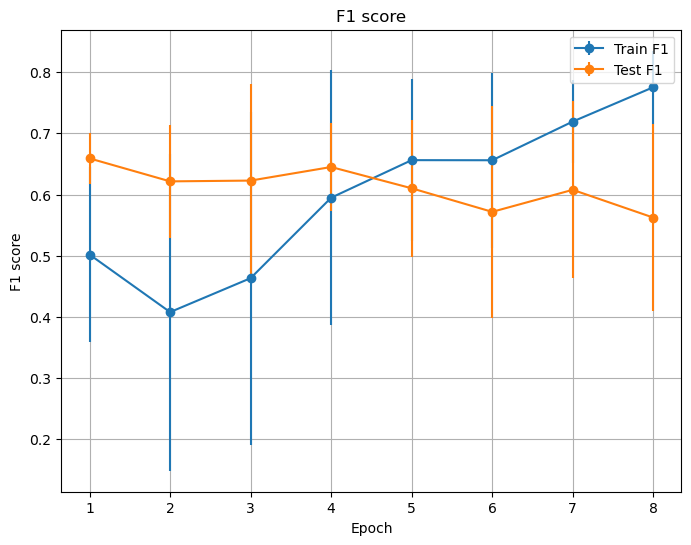

In [54]:
china_cut_new_aug_f1 = conduct_experiments_aug(data, augmented_data, labels, aug_labels, conv_output_size=2912)

In [55]:
combined_data = torch.cat((data, augmented_data), axis=0)
combined_labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) +\
 [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample)
combined_labels = torch.tensor(combined_labels).float()

Epoch 1/8, Train loss: 2.1130, Test loss: 0.7448
Epoch 1/8, Train loss: 1.2797, Test loss: 0.9299
Epoch 1/8, Train loss: 1.6677, Test loss: 0.7177
Epoch 1/8, Train loss: 1.9166, Test loss: 0.7153
Epoch 1/8, Train loss: 1.1107, Test loss: 0.7207
Epoch 1/8, Train loss: 1.6211, Test loss: 0.7045
Epoch 1/8, Train loss: 1.6553, Test loss: 0.7469
Epoch 1/8, Train loss: 1.5454, Test loss: 0.7028
Epoch 1/8, Train loss: 1.8680, Test loss: 0.7504
Epoch 1/8, Train loss: 1.2671, Test loss: 0.8468
Epoch 1/8, Train loss: 1.2118, Test loss: 0.8521
Epoch 1/8, Train loss: 2.0624, Test loss: 0.7102
Epoch 1/8, Train loss: 1.6971, Test loss: 0.7332
Epoch 1/8, Train loss: 1.6324, Test loss: 0.8299
Epoch 1/8, Train loss: 1.5312, Test loss: 0.6930


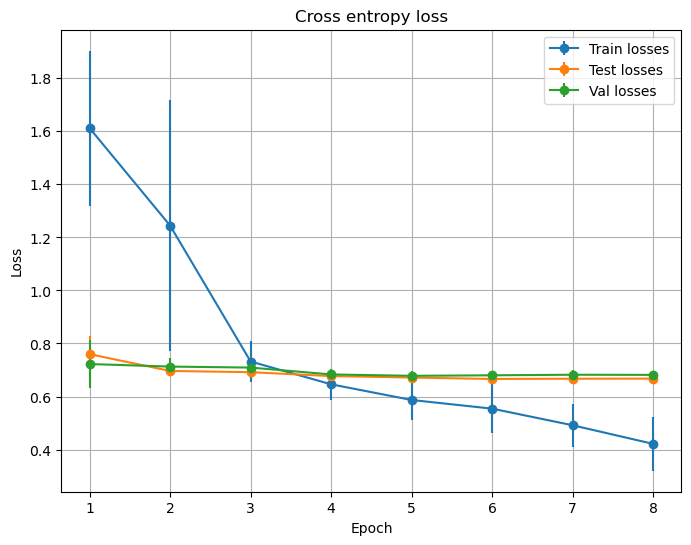

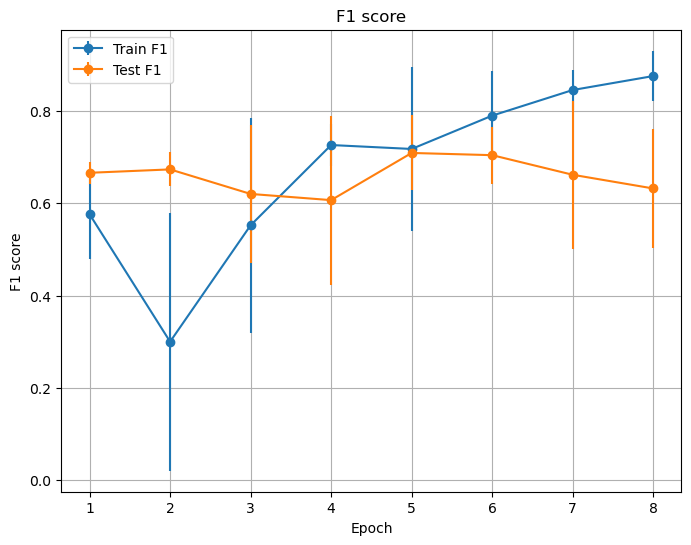

In [56]:
china_cut_new_comb_f1 = conduct_experiments_aug(data, combined_data, labels, combined_labels, conv_output_size=2912)

## Результаты China cut

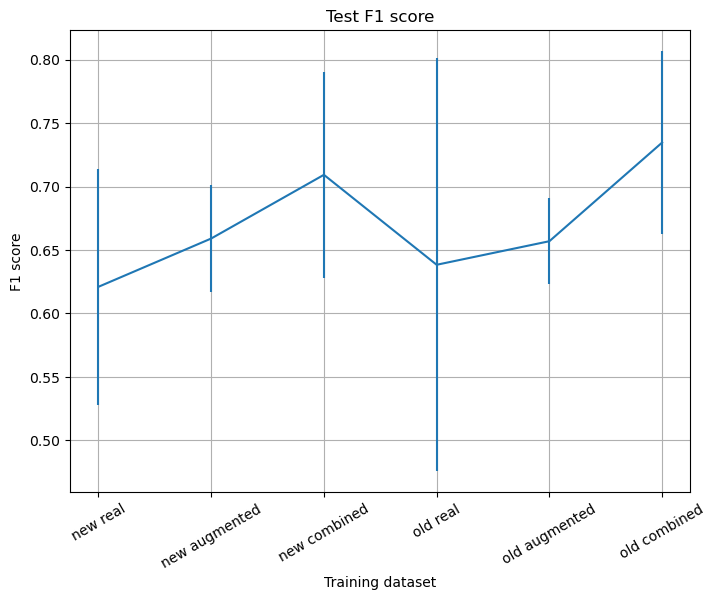

In [ ]:
plot_results(china_cut_new_real_f1, china_cut_new_aug_f1, china_cut_new_comb_f1,
             china_cut_old_real_f1, china_cut_old_aug_f1, china_cut_old_comb_f1)

## Обучение на данных Тани

In [9]:
closed = torch.load("aug_closed.pt")
opened = torch.load("aug_opened.pt")

In [10]:
closed.shape

torch.Size([84, 120, 14])

In [12]:
close, open, data = load_data("ihb")

In [19]:
labels = [1] * (close.shape[1]) + [0] * (open.shape[1]) # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()
aug_labels = [1] * (close.shape[1] * augments_per_sample) + [0] * (open.shape[1] * augments_per_sample) # 1 - closed, 0 - opened
aug_labels = torch.tensor(aug_labels).float()

In [19]:
augmented_data = np.concatenate((closed, opened), axis=0)
augmented_data = torch.tensor(augmented_data).float()
augmented_data = augmented_data.reshape((augmented_data.shape[0], augmented_data.shape[2], augmented_data.shape[1]))

In [20]:
augmented_data.shape, data.shape

(torch.Size([168, 14, 120]), torch.Size([168, 14, 120]))

In [22]:
labels.shape, aug_labels.shape

(torch.Size([240]), torch.Size([240]))

Epoch 1/5, Train loss: 0.7411, Test loss: 0.7150
Epoch 1/5, Train loss: 0.7158, Test loss: 0.6907
Epoch 1/5, Train loss: 0.7369, Test loss: 0.6984
Epoch 1/5, Train loss: 0.7538, Test loss: 0.6896
Epoch 1/5, Train loss: 0.7443, Test loss: 0.7035
Epoch 1/5, Train loss: 0.7357, Test loss: 0.7085
Epoch 1/5, Train loss: 0.7142, Test loss: 0.7049
Epoch 1/5, Train loss: 0.7370, Test loss: 0.6924
Epoch 1/5, Train loss: 0.7404, Test loss: 0.6970
Epoch 1/5, Train loss: 0.7388, Test loss: 0.6952
Epoch 1/5, Train loss: 0.7665, Test loss: 0.7115
Epoch 1/5, Train loss: 0.8251, Test loss: 0.7152
Epoch 1/5, Train loss: 0.7035, Test loss: 0.6984
Epoch 1/5, Train loss: 0.6996, Test loss: 0.6866
Epoch 1/5, Train loss: 0.7060, Test loss: 0.6875


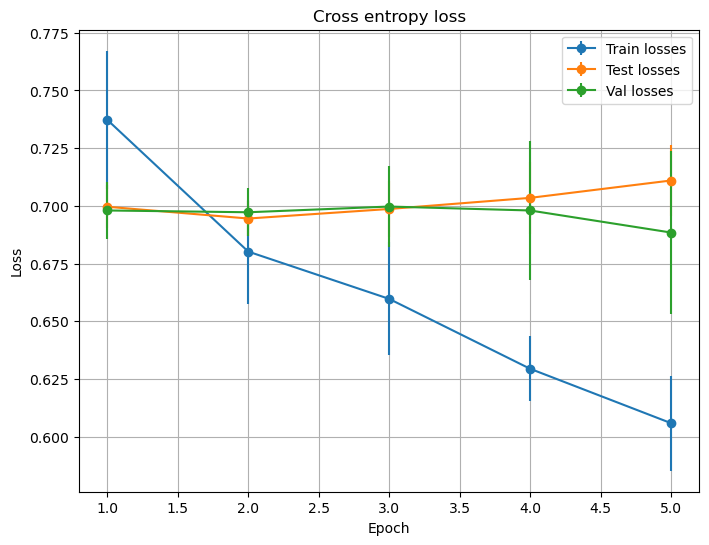

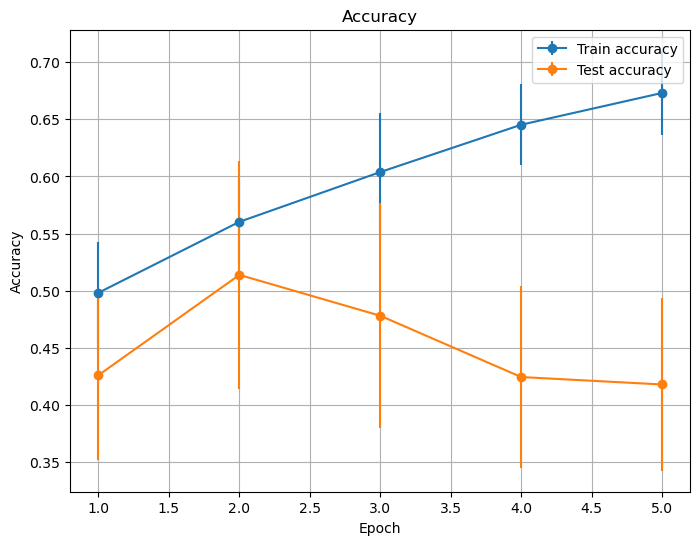

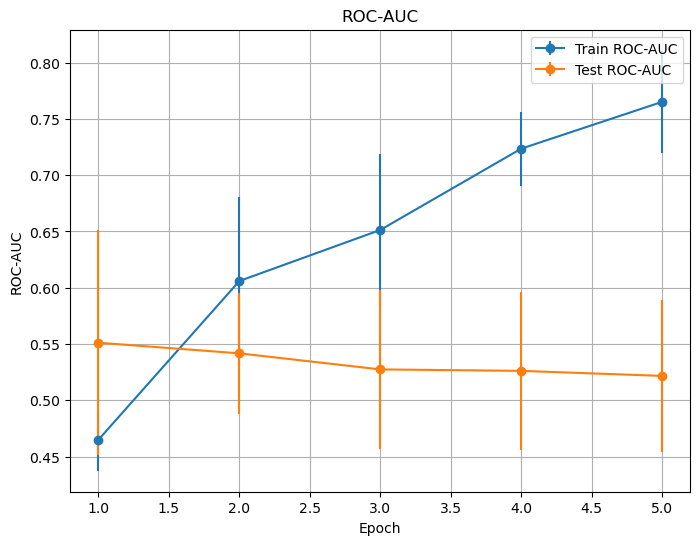

(array([[0.3902439 , 0.3902439 , 0.46341463, 0.46341463, 0.3902439 ],
        [0.53658537, 0.43902439, 0.68292683, 0.63414634, 0.65853659],
        [0.3902439 , 0.68292683, 0.41463415, 0.36585366, 0.3902439 ],
        [0.58536585, 0.65853659, 0.63414634, 0.31707317, 0.34146341],
        [0.36585366, 0.6097561 , 0.46341463, 0.41463415, 0.3902439 ],
        [0.3902439 , 0.41463415, 0.3902439 , 0.36585366, 0.48780488],
        [0.3902439 , 0.3902439 , 0.53658537, 0.46341463, 0.41463415],
        [0.43902439, 0.53658537, 0.41463415, 0.3902439 , 0.43902439],
        [0.3902439 , 0.6097561 , 0.34146341, 0.31707317, 0.31707317],
        [0.36585366, 0.6097561 , 0.3902439 , 0.36585366, 0.3902439 ],
        [0.3902439 , 0.56097561, 0.63414634, 0.48780488, 0.36585366],
        [0.3902439 , 0.51219512, 0.3902439 , 0.3902439 , 0.43902439],
        [0.41463415, 0.3902439 , 0.48780488, 0.48780488, 0.41463415],
        [0.36585366, 0.46341463, 0.43902439, 0.48780488, 0.41463415],
        [0.58536585,

In [24]:
conduct_experiments_aug(data, augmented_data, labels, aug_labels)

In [9]:
augmented_data = torch.load("fmri/aug_data_tanya_ihb.pt")

Epoch 1/5, Train loss: 0.6778, Test loss: 0.7088
Epoch 1/5, Train loss: 0.6883, Test loss: 0.7125
Epoch 1/5, Train loss: 0.6930, Test loss: 0.7143
Epoch 1/5, Train loss: 0.7594, Test loss: 0.8093
Epoch 1/5, Train loss: 0.7201, Test loss: 0.7055
Epoch 1/5, Train loss: 0.7058, Test loss: 0.6898
Epoch 1/5, Train loss: 0.7363, Test loss: 0.6936
Epoch 1/5, Train loss: 0.6946, Test loss: 0.7347
Epoch 1/5, Train loss: 0.6251, Test loss: 0.7942
Epoch 1/5, Train loss: 0.7417, Test loss: 0.7782
Epoch 1/5, Train loss: 0.7312, Test loss: 0.7005
Epoch 1/5, Train loss: 0.6789, Test loss: 0.7023
Epoch 1/5, Train loss: 0.7421, Test loss: 0.7190
Epoch 1/5, Train loss: 0.6614, Test loss: 0.7521
Epoch 1/5, Train loss: 0.7631, Test loss: 0.7244


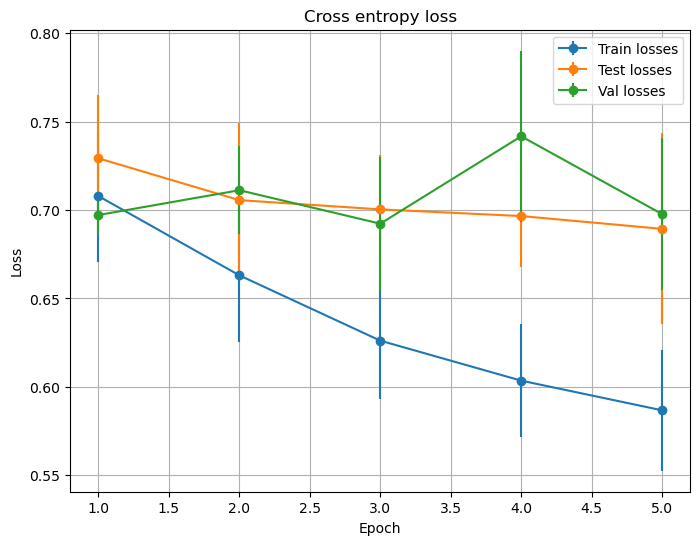

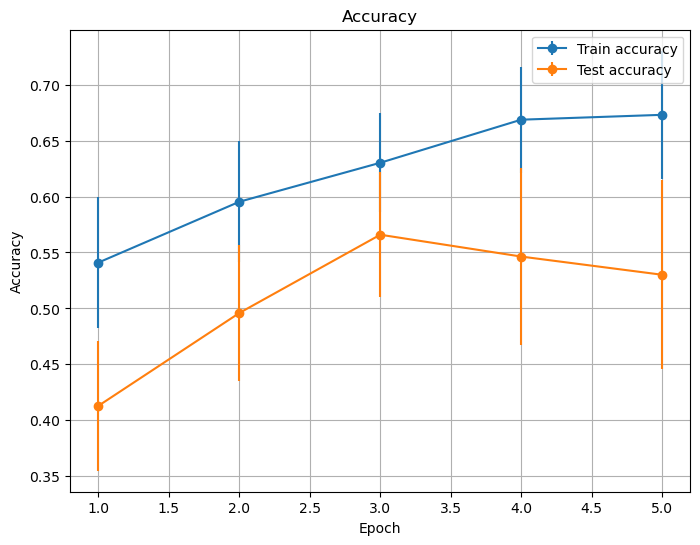

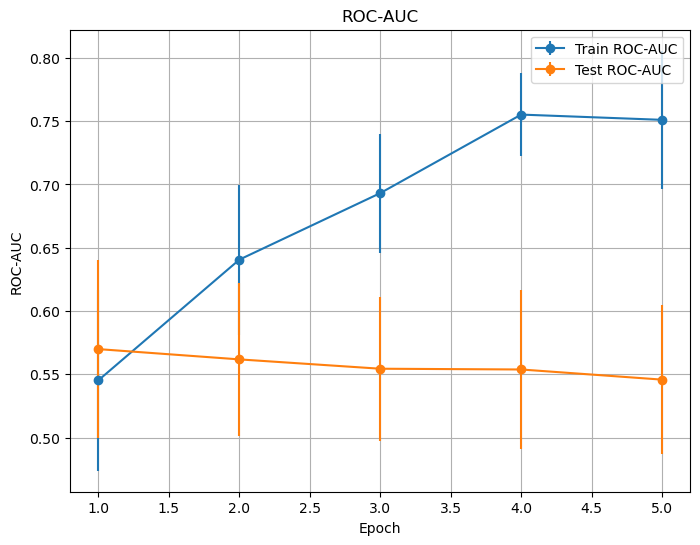

(array([[0.41463415, 0.58536585, 0.58536585, 0.56097561, 0.56097561],
        [0.3902439 , 0.3902439 , 0.63414634, 0.36585366, 0.3902439 ],
        [0.46341463, 0.51219512, 0.58536585, 0.58536585, 0.56097561],
        [0.36585366, 0.51219512, 0.41463415, 0.43902439, 0.43902439],
        [0.53658537, 0.53658537, 0.53658537, 0.65853659, 0.63414634],
        [0.3902439 , 0.46341463, 0.58536585, 0.6097561 , 0.58536585],
        [0.3902439 , 0.43902439, 0.63414634, 0.46341463, 0.3902439 ],
        [0.3902439 , 0.53658537, 0.56097561, 0.65853659, 0.63414634],
        [0.3902439 , 0.46341463, 0.58536585, 0.58536585, 0.58536585],
        [0.36585366, 0.51219512, 0.51219512, 0.48780488, 0.48780488],
        [0.3902439 , 0.48780488, 0.58536585, 0.58536585, 0.56097561],
        [0.3902439 , 0.36585366, 0.6097561 , 0.51219512, 0.3902439 ],
        [0.56097561, 0.58536585, 0.58536585, 0.58536585, 0.58536585],
        [0.3902439 , 0.51219512, 0.48780488, 0.51219512, 0.56097561],
        [0.36585366,

In [22]:
conduct_experiments_aug(data, augmented_data, labels, aug_labels)

In [16]:
data.shape

torch.Size([168, 14, 120])

In [17]:
augmented_data.shape

torch.Size([168, 14, 120])

In [18]:
labels.shape

torch.Size([28])